# Data Transformation From pdf to json

The goal here is to transform the pdf into a json format to be exploitable by the LLM
The Json will be like this : 

{
    
        Instruction : a string witch say what want the user

        
        Input : the equivalence of a sheet with those info : 
            - The goal distance(None, distance[5km,1miles, etc...])   
            - The goal time (None, time[30minutes, below 1hours, etc...])
            - The level (None, level[beginner, advanced, ect...])  
            - The Number of weeks before the run, or of training (None, weeks[10, 20, 1years, etc...])  
            - The Number of training by weeks (None, 1, 2, 4, ect...) 
            - The age (None, 40, 50, etc...)


        Ouput : The equivalence of a 2D sheet with 8 Collums :
            - The week (first week, second, ect...)  
            - Monday
            - Tuesday
            - Wednesday
            - ....
            - Sunday        

}

None means that there are no info about it (for example None for the age means everyone can do it)

# Data Transformation For Training

In [ ]:
import json
import os
import sys
import requests
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader
from functools import partial
from tqdm import tqdm
import time
import re

# Load the NEW augmented training dataset
print("Loading augmented training dataset...")
with open("Data/running_week_training_dataset_final_3.json", "r", encoding="utf-8") as file:
    dataset_full = json.load(file)

# Extract training data and metadata
training_data = dataset_full.get("training_data", [])
metadata = dataset_full.get("metadata", {})
stats = metadata.get("statistics", {})

print(f"\n{'='*80}")
print("AUGMENTED DATASET STATISTICS")
print(f"{'='*80}")
print(f"Total training examples: {len(training_data)}")
print(f"Dataset generated with {metadata.get('augmentation_factor', 'N/A')}x augmentation")
print(f"Original weeks: {metadata.get('total_weeks', 'N/A')}")

print(f"\nDistribution by level:")
for level, count in stats.get('by_level', {}).items():
    percentage = (count / max(len(training_data), 1)) * 100
    print(f"  {level}: {count} ({percentage:.1f}%)")

print(f"\nDistribution by goal:")
for goal, count in stats.get('by_goal', {}).items():
    percentage = (count / max(len(training_data), 1)) * 100
    print(f"  {goal}: {count} ({percentage:.1f}%)")

print(f"\nDistribution by training days:")
for days, count in stats.get('by_training_days', {}).items():
    percentage = (count / max(len(training_data), 1)) * 100
    print(f"  {days}d: {count} ({percentage:.1f}%)")

print(f"\n{'='*80}\n")

# Data quality filter: keep weeks with at least 2 non-rest days and 7 lines
day_pattern = re.compile(r"^(lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche)\s*:", re.IGNORECASE)
rest_pattern = re.compile(r"\b(rest|day off)\b", re.IGNORECASE)

MIN_NON_REST_DAYS = 2
MIN_NON_REST_CHARS = 12

# We keep richness/diversity as *weights* (sampling), not by duplicating examples.
# NOTE: we bias sampling towards weeks that contain at least one "quality" session
# (Intervals/Tempo/Marathon pace) + Long Run to fight the "all short runs" collapse.
RICHNESS_BOOST_THRESHOLD = 18
DIVERSITY_BOOST_THRESHOLD = 3
RICHNESS_WEIGHT_BOOST = 0.5
DIVERSITY_WEIGHT_BOOST = 0.8
QUALITY_WEIGHT_BOOST = 0.9
LONG_RUN_WEIGHT_BOOST = 0.6
EASY_HEAVY_PENALTY = 0.35

# Input augmentation: generate short / partial user-like queries
MAX_INPUT_VARIANTS_PER_ENTRY = 4


def normalize_output_text(output_text: str) -> str:
    """Normalize outputs to reduce label noise.

    - Remove template markers (safety)
    - Replace 'Easy Run' -> 'Run' (keep 'Long Run')
    """
    if not output_text:
        return ""
    t = output_text.replace("<|endoftext|>", "")
    # Remove any template delimiters if they ever leaked in
    t = re.sub(r"###\s*(instruction|input|response)\s*:\s*", "", t, flags=re.IGNORECASE)
    # Normalize whitespace
    t = t.replace("\r\n", "\n").replace("\r", "\n")
    # Replace Easy Run by Run (case-insensitive)
    t = re.sub(r"\bEasy\s+Run\b", "Run", t, flags=re.IGNORECASE)
    return t.strip()


def richness_score(output_text: str) -> float:
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    non_rest_lines = [l for l in lines[:7] if not rest_pattern.search(l)]
    if not non_rest_lines:
        return 0.0
    return sum(len(l) for l in non_rest_lines) / len(non_rest_lines)


def diversity_score(output_text: str) -> int:
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    non_rest_lines = [l for l in lines[:7] if not rest_pattern.search(l)]
    activities = set()
    for line in non_rest_lines:
        lower = line.lower()
        if "long run" in lower:
            activities.add("long")
        if "interval" in lower or "repeats" in lower:
            activities.add("interval")
        if "tempo" in lower:
            activities.add("tempo")
        if "marathon pace" in lower or "threshold" in lower:
            activities.add("pace")
        if "recovery" in lower:
            activities.add("recovery")
        # After normalization, 'Easy Run' becomes 'Run'
        if re.search(r"\brun\b", lower):
            activities.add("run")
    return len(activities)


def easy_heavy_ratio(output_text: str) -> float:
    """Fraction of non-rest lines that are plain 'Run' (no long/interval/tempo/pace)."""
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    non_rest_lines = [l for l in lines[:7] if not rest_pattern.search(l)]
    if not non_rest_lines:
        return 0.0

    def is_plain_run(line: str) -> bool:
        s = line.lower()
        if "long run" in s:
            return False
        if any(k in s for k in ["interval", "tempo", "marathon pace", "threshold", "repeats", "fartlek", "hill"]):
            return False
        return " run" in s or s.endswith("run")

    plain = sum(1 for l in non_rest_lines if is_plain_run(l))
    return plain / max(1, len(non_rest_lines))


def has_quality_session(output_text: str) -> bool:
    s = (output_text or "").lower()
    return any(k in s for k in ["interval", "tempo", "marathon pace", "threshold", "repeats", "fartlek", "hill"])


def has_long_run(output_text: str) -> bool:
    return "long run" in (output_text or "").lower()


def is_good_example(output_text: str) -> bool:
    if not output_text:
        return False
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    if len(lines) < 7:
        return False
    if sum(1 for l in lines[:7] if day_pattern.search(l)) < 5:
        return False
    non_rest = [l for l in lines[:7] if not rest_pattern.search(l)]
    if len(non_rest) < MIN_NON_REST_DAYS:
        return False
    avg_len = sum(len(l) for l in non_rest) / len(non_rest)
    return avg_len >= MIN_NON_REST_CHARS


def parse_profile_from_input(input_text: str) -> dict:
    """Parse the structured 'Objectif: ...; Niveau: ...;' input into a dict (best-effort)."""
    if not input_text:
        return {}
    fields = {}
    patterns = {
        "goal": r"Objectif\s*:\s*([^;\.]+)",
        "level": r"Niveau\s*:\s*([^;\.]+)",
        "weeks": r"Semaines\s*:\s*([^;\.]+)",
        "sessions": r"Séances/sem\s*:\s*([^;\.]+)",
        "time": r"Temps objectif\s*:\s*([^;\.]+)",
    }
    for key, pat in patterns.items():
        m = re.search(pat, input_text, flags=re.IGNORECASE)
        if m:
            fields[key] = m.group(1).strip()
    return fields


def normalize_goal_text(goal: str) -> str:
    if not goal:
        return ""
    g = goal.strip().lower()
    # unify 10km / 10 km
    m = re.match(r"^(\d+(?:\.\d+)?)\s*km$", g)
    if m:
        return f"{m.group(1)} km"
    if g == "semi-marathon":
        return "semi-marathon"
    return goal.strip()


def generate_input_variations(input_text: str) -> list[str]:
    """Generate short/partial inputs to cover real user queries."""
    profile = parse_profile_from_input(input_text)
    goal = normalize_goal_text(profile.get("goal", ""))
    level = profile.get("level", "").strip() if profile.get("level") else ""
    weeks = profile.get("weeks", "").strip() if profile.get("weeks") else ""
    sessions = profile.get("sessions", "").strip() if profile.get("sessions") else ""
    goal_time = profile.get("time", "").strip() if profile.get("time") else ""

    variants = []

    def add(s: str):
        s = (s or "").strip()
        if not s:
            return
        s = " ".join(s.split())
        variants.append(s)

    # Always keep the original structured input
    add(input_text)

    # Very short goal/level queries
    if goal:
        add(f"entrainement {goal}")
        add(goal)
    if level:
        add(f"entrainement {level}")
        add(level)
    if goal and level:
        add(f"entrainement {goal} {level}")
        add(f"plan {goal} niveau {level}")
    if goal and sessions:
        add(f"plan {goal} {sessions} séances par semaine")
    if goal and weeks:
        add(f"plan {goal} {weeks} semaines")
    if weeks and sessions:
        add(f"plan {weeks} semaines {sessions} séances")
    if goal_time and goal:
        add(f"objectif {goal_time} {goal}")

    # Deduplicate, keep order, cap variants
    seen = set()
    out = []
    for v in variants:
        k = v.lower()
        if k in seen:
            continue
        seen.add(k)
        out.append(v)
        if len(out) >= MAX_INPUT_VARIANTS_PER_ENTRY:
            break
    return out


# Normalize outputs before filtering/weighting
normalized_training_data = []
for e in training_data:
    e2 = dict(e)
    e2["output"] = normalize_output_text(e.get("output", ""))
    normalized_training_data.append(e2)

filtered_training_data = [e for e in normalized_training_data if is_good_example(e.get("output", ""))]
print(f"Filtered examples kept: {len(filtered_training_data)} / {len(training_data)}")


# Compute weights (no duplication): sample more diverse/quality weeks

def example_weight(entry: dict) -> float:
    out = entry.get("output", "") or ""
    w = 1.0

    if richness_score(out) >= RICHNESS_BOOST_THRESHOLD:
        w += RICHNESS_WEIGHT_BOOST

    if diversity_score(out) >= DIVERSITY_BOOST_THRESHOLD:
        w += DIVERSITY_WEIGHT_BOOST

    if has_quality_session(out):
        w += QUALITY_WEIGHT_BOOST

    if has_long_run(out):
        w += LONG_RUN_WEIGHT_BOOST

    # Penalize weeks that are mostly plain runs (too repetitive)
    if easy_heavy_ratio(out) >= 0.65:
        w -= EASY_HEAVY_PENALTY

    return float(max(0.2, w))


# Keep only essential metadata to avoid overfitting on workout_types/noisy fields
ESSENTIAL_METADATA_KEYS = {
    "program",
    "week",
    "total_weeks",
    "training_days",
    "goal",
    "level",
}


def prune_metadata(meta: dict) -> dict:
    if not isinstance(meta, dict):
        return {}
    return {k: meta.get(k) for k in ESSENTIAL_METADATA_KEYS if k in meta}


# Transform to instruction format compatible with our model, with INPUT augmentation + weights
instruction_data = []
for entry in filtered_training_data:
    base_weight = example_weight(entry)
    input_variants = generate_input_variations(entry.get("input", ""))
    if not input_variants:
        input_variants = [""]

    # Split the base weight across variants so we don't overweight a single week
    per_variant_weight = base_weight / max(1, len(input_variants))

    for v in input_variants:
        instruction_data.append({
            "instruction": entry.get("instruction", ""),
            "input": v,
            "output": entry.get("output", ""),
            "metadata": prune_metadata(entry.get("metadata", {})),
            "weight": per_variant_weight,
        })

print(f"Total instruction examples prepared: {len(instruction_data)}")
if len(instruction_data) > 0:
    # pick a better example with more non-rest days
    best_entry = max(
        instruction_data,
        key=lambda e: sum(1 for l in e['output'].split('\n') if l.strip() and not rest_pattern.search(l)),
    )
    print(f"\nExample entry (filtered, week-level format):")
    print(json.dumps(best_entry, indent=2, ensure_ascii=False))

# Quick sanity checks
if instruction_data:
    weights = [e.get("weight", 1.0) for e in instruction_data]
    print(f"\nWeight stats: min={min(weights):.2f}  max={max(weights):.2f}  mean={sum(weights)/len(weights):.2f}")

    # How many outputs still contain 'Easy Run' after normalization?
    easy_left = sum(1 for e in instruction_data if "easy run" in (e.get("output", "").lower()))
    print(f"Outputs still containing 'Easy Run': {easy_left} / {len(instruction_data)}")

    print("Input variants examples:")
    for s in generate_input_variations(best_entry.get("input", ""))[:MAX_INPUT_VARIANTS_PER_ENTRY]:
        print("  -", s)

    # Diversity quick stats
    ds = [diversity_score(e["output"]) for e in instruction_data[:1000]]
    if ds:
        print(f"Diversity score (sample 1k): min={min(ds)} max={max(ds)} mean={sum(ds)/len(ds):.2f}")

Loading augmented training dataset...

AUGMENTED DATASET STATISTICS
Total training examples: 26552
Dataset generated with 2x augmentation
Original weeks: N/A

Distribution by level:
  general: 16816 (63.3%)
  maintenance: 440 (1.7%)
  beginner: 3736 (14.1%)
  advanced: 4208 (15.8%)
  intermediate: 1352 (5.1%)

Distribution by goal:
  marathon: 18616 (70.1%)
  general fitness: 596 (2.2%)
  16.1km: 56 (0.2%)
  halfmarathon: 5044 (19.0%)
  5km: 1400 (5.3%)
  10km: 672 (2.5%)
  1.6km: 168 (0.6%)

Distribution by training days:
  4d: 5332 (20.1%)
  5d: 13088 (49.3%)
  6d: 7560 (28.5%)
  7d: 520 (2.0%)
  3d: 52 (0.2%)


Filtered examples kept: 26552 / 26552
Total instruction examples prepared: 32660

Example entry (filtered, week-level format):
{
  "instruction": "Generate a complete week (2) of a 19-week marathon running program. Training level: general, 6 training days per week. Format attendu: 7 lignes, une par jour, de Lundi à Dimanche, au format 'Jour: Activité'.",
  "input": "Objectif:

# Format Input & Load Tokenizer

In [2]:
def format_input(entry):
    """Format instruction data in Alpaca-style prompt format"""
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

# Load tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Pick a more informative example for preview
best_entry = max(
    instruction_data,
    key=lambda e: sum(1 for l in e["output"].split("\n") if l.strip() and "rest" not in l.lower()),
)

# Test formatting
model_input = format_input(best_entry)
desired_response = f"\n\n### Response:\n{best_entry['output']}"

print("Example formatted prompt (first 1000 characters):")
print((model_input + desired_response)[:1000])
print(f"\nTotal length: {len(model_input + desired_response)} characters")

Example formatted prompt (first 1000 characters):
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a complete week (2) of a 19-week marathon running program. Training level: general, 6 training days per week. Format attendu: 7 lignes, une par jour, de Lundi à Dimanche, au format 'Jour: Activité'.

### Input:
Objectif: marathon; Niveau: general; Semaines: 19; Séances/sem: 6; Temps objectif: 3h30m.

### Response:
Lundi: 8.0km Run
Mardi: 5.0km Run
Mercredi: 5 km
Jeudi: 5.0km Run
Vendredi: 8.0km Run
Samedi: Rest
Dimanche: 18.0km Long Run

Total length: 573 characters


# Split Data into Train/Val/Test

In [3]:
import random

# Split dataset with random shuffle to reduce ordering bias
seed = 42
random.seed(seed)
shuffled = instruction_data.copy()
random.shuffle(shuffled)

train_portion = int(len(shuffled) * 0.7)   # 70% for training
val_portion = int(len(shuffled) * 0.15)    # 15% for validation
test_portion = len(shuffled) - train_portion - val_portion  # 15% for testing

train_data = shuffled[:train_portion]
val_data = shuffled[train_portion:train_portion + val_portion]
test_data = shuffled[train_portion + val_portion:]

print(f"Total dataset size: {len(shuffled)}")
print(f"Training set length: {len(train_data)} ({len(train_data)/len(shuffled)*100:.1f}%)")
print(f"Validation set length: {len(val_data)} ({len(val_data)/len(shuffled)*100:.1f}%)")
print(f"Test set length: {len(test_data)} ({len(test_data)/len(shuffled)*100:.1f}%)")
print(f"Shuffle seed: {seed}")

Total dataset size: 32660
Training set length: 22862 (70.0%)
Validation set length: 4899 (15.0%)
Test set length: 4899 (15.0%)
Shuffle seed: 42


# Create Dataset and DataLoaders

In [4]:
class InstructionDataset(Dataset):
    """Dataset for instruction-following training"""
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        self.weights = []
        
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
            self.weights.append(float(entry.get("weight", 1.0)))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)


def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
    ):
    """Custom collate function for batching sequences"""
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)
    
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    # Convert to tensors and transfer to device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor


# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

# Create custom collate function with device
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024,
    )

# Create datasets
train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

# Create data loaders
batch_size = 2
num_workers = 0

torch.manual_seed(123)

# Weighted sampling for training (reduces repetition bias vs duplicating rows)
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=torch.tensor(train_dataset.weights, dtype=torch.double),
    num_samples=len(train_dataset),
    replacement=True,
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    sampler=train_sampler,
    drop_last=True,
    num_workers=num_workers
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
    )

print("\nTrain loader batches:")
for i, (inputs, targets) in enumerate(train_loader):
    if i < 2:
        print(f"Batch {i}: inputs shape {inputs.shape}, targets shape {targets.shape}")
    else:
        break

Device: cpu

Train loader batches:
Batch 0: inputs shape torch.Size([2, 157]), targets shape torch.Size([2, 157])
Batch 1: inputs shape torch.Size([2, 157]), targets shape torch.Size([2, 157])


# Load Pretrained GPT-2 Model
Note: This section loads a GPT-2 small model (124M) for faster training. You can modify the model size in the configuration below.

In [5]:
# For this demonstration, we'll create a simple GPT-like model
# since we need a minimal model for training on CPU/limited GPU

class SimpleGPT(nn.Module):
    """Simplified GPT model for instruction finetuning"""
    def __init__(self, vocab_size=50257, embedding_dim=256, n_layers=4, n_heads=4, context_length=1024):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(context_length, embedding_dim)
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=512,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Output layer
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, input_ids):
        seq_len = input_ids.size(1)
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        
        token_emb = self.token_embedding(input_ids)
        pos_emb = self.pos_embedding(pos_ids)
        x = token_emb + pos_emb
        
        x = self.transformer(x)
        logits = self.output_layer(x)
        return logits

# Initialize model
model = SimpleGPT(
    vocab_size=50257,
    embedding_dim=256,
    n_layers=4,
    n_heads=4,
    context_length=1024
)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
SimpleGPT(
  (token_embedding): Embedding(50257, 256)
  (pos_embedding): Embedding(1024, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=256, out_features=50257, bias=True)
)

Total parameters: 28,152,401


# Training Setup and Loss Functions

In [6]:
# Lower weight for Rest tokens to reduce overfitting
REST_TOKEN_IDS = set()
for token in [" Rest", " rest", "Rest", "rest"]:
    REST_TOKEN_IDS.update(tokenizer.encode(token))
REST_TOKEN_WEIGHT = 0.3
VOCAB_SIZE = 50257
TOKEN_WEIGHTS = torch.ones(VOCAB_SIZE)
for tid in REST_TOKEN_IDS:
    if 0 <= tid < VOCAB_SIZE:
        TOKEN_WEIGHTS[tid] = REST_TOKEN_WEIGHT

def calc_loss_batch(input_batch, target_batch, model, device):
    """Calculate loss for a batch"""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)
    
    # Reshape for loss calculation
    logits_flat = logits.view(-1, logits.size(-1))
    targets_flat = target_batch.view(-1)
    
    # Use CrossEntropyLoss with ignore_index and lower weight for Rest tokens
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100, weight=TOKEN_WEIGHTS.to(device))
    loss = loss_fn(logits_flat, targets_flat)
    
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Calculate average loss over data loader"""
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
            if num_batches is not None and batch_idx >= num_batches:
                break
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
            total_batches += 1
    
    return total_loss / total_batches if total_batches > 0 else float('inf')


# Move model to device
model.to(device)

# Calculate initial loss
print("Calculating initial losses...")
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Initial Training loss: {train_loss:.4f}")
print(f"Initial Validation loss: {val_loss:.4f}")

Calculating initial losses...
Initial Training loss: 10.9805
Initial Validation loss: 10.9810


# Train the Model

In [7]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq):
    """Train the model with validation and week-level generation"""
    train_losses, val_losses = [], []
    week_coherence_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_batches = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for input_batch, target_batch in progress_bar:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            train_batches += 1
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        avg_val_loss = calc_loss_loader(val_loader, model, device)
        val_losses.append(avg_val_loss)
        
        print(f"\nEpoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
        
        # Week generation evaluation (every 2 epochs or at end)
        if (epoch + 1) % eval_freq == 0 or epoch == num_epochs - 1:
            print(f"\n--- Week Generation Evaluation (Epoch {epoch+1}) ---")
            coherence = evaluate_week_generation(model, test_data[:5], tokenizer, device)
            week_coherence_scores.append(coherence)
            print(f"Week Coherence Score: {coherence:.1f}%\n")
    
    return train_losses, val_losses, week_coherence_scores


def evaluate_week_generation(model, test_samples, tokenizer, device, max_tokens=300):
    """
    Evaluate week generation by checking:
    1. Does it generate 7+ lines (roughly one per day)?
    2. Does it contain recognizable training terms?
    3. Does it have varied activities (not all "Rest")?
    """
    model.eval()
    coherence_scores = []
    
    training_keywords = ['rest', 'run', 'easy', 'tempo', 'interval', 'cross', 'long', 'mile', 'km', 'repeats', 'track', 'warm', 'cool']
    
    with torch.no_grad():
        for entry in test_samples:
            # Generate prediction using the instruction format
            prompt = (
                f"Below is an instruction that describes a task. "
                f"Write a response that appropriately completes the request."
                f"\n\n### Instruction:\n{entry['instruction']}"
            )
            if entry.get('input'):
                prompt += f"\n\n### Input:\n{entry['input']}"
            prompt += f"\n\n### Response:\n"
            
            input_ids = tokenizer.encode(prompt)
            input_ids = torch.tensor([input_ids[:1024]], dtype=torch.long).to(device)
            
            # Generate with greedy decoding
            output_ids = input_ids.clone()
            for _ in range(max_tokens):
                logits = model(output_ids)
                next_token_logits = logits[0, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1)
                output_ids = torch.cat([output_ids, next_token.view(1, 1)], dim=1)
                
                if next_token.item() == 50256:  # endoftext
                    break
            
            # Decode and evaluate
            generated_text = tokenizer.decode(output_ids[0].cpu().numpy())
            generated = generated_text.split("### Response:\n")[-1].strip()
            
            # Scoring criteria
            score = 0
            
            # 1. Check number of lines (should have ~7 for a week)
            lines = [l for l in generated.split('\n') if l.strip()]
            if 5 <= len(lines) <= 9:
                score += 30
            elif len(lines) >= 3:
                score += 15
            
            # 2. Check for training keywords
            text_lower = generated.lower()
            keyword_count = sum(1 for kw in training_keywords if kw in text_lower)
            score += min(40, keyword_count * 5)  # Max 40 points
            
            # 3. Check for variety (not all same activity)
            if text_lower.count('rest') < len(lines) * 0.8:  # Not all rest
                score += 30
            
            coherence_scores.append(min(100, score))
    
    return sum(coherence_scores) / len(coherence_scores) if coherence_scores else 0


# Training parameters - optimized for 1716 augmented examples
num_epochs = 4  # Increased from 3 to better leverage more data
learning_rate = 0.0001  # More conservative learning rate for stability
batch_size = 8  # Increased for better gradient estimates with more data

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

print("="*80)
print("TRAINING AVEC LE NOUVEAU DATASET AUGMENTÉ")
print("="*80)
print(f"Epochs: {num_epochs}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Total Training Examples: {len(train_data)}")
print(f"Training Batches per Epoch: {len(train_loader)}")
print("="*80 + "\n")

print("Starting training with week generation evaluation...")
start_time = time.time()

train_losses, val_losses, week_coherence_scores = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=2  # Evaluate every 2 epochs
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"\n{'='*80}")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
if len(week_coherence_scores) > 0:
    print(f"Final week coherence score: {week_coherence_scores[-1]:.1f}%")
print(f"{'='*80}")


TRAINING AVEC LE NOUVEAU DATASET AUGMENTÉ
Epochs: 4
Learning Rate: 0.0001
Batch Size: 8
Total Training Examples: 22862
Training Batches per Epoch: 11431

Starting training with week generation evaluation...


Epoch 1/4: 100%|██████████| 11431/11431 [37:13<00:00,  5.12it/s, loss=0.018]   



Epoch 1: Train Loss=0.2801, Val Loss=0.0027


Epoch 2/4: 100%|██████████| 11431/11431 [41:49<00:00,  4.56it/s, loss=0.00236] 



Epoch 2: Train Loss=0.0033, Val Loss=0.0004

--- Week Generation Evaluation (Epoch 2) ---
Week Coherence Score: 54.0%



Epoch 3/4: 100%|██████████| 11431/11431 [41:31<00:00,  4.59it/s, loss=9.13e-5] 



Epoch 3: Train Loss=0.0011, Val Loss=0.0001


Epoch 4/4: 100%|██████████| 11431/11431 [41:30<00:00,  4.59it/s, loss=5.37e-5] 



Epoch 4: Train Loss=0.0007, Val Loss=0.0001

--- Week Generation Evaluation (Epoch 4) ---
Week Coherence Score: 65.0%


Training completed in 169.43 minutes.
Final week coherence score: 65.0%


# Visualize Training Results

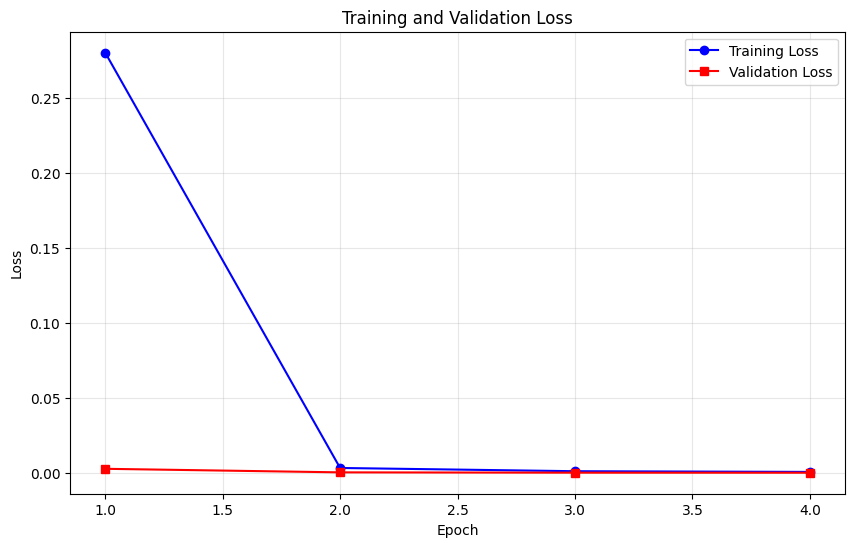


Final Training Loss: 0.0007
Final Validation Loss: 0.0001


In [8]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [ ]:
import re

print("\n" + "="*80)
print("GÉNÉRATION D'UNE SEMAINE COMPLÈTE D'ENTRAÎNEMENT (TOP-K SAMPLING)")
print("="*80 + "\n")


def apply_repetition_penalty(logits, generated_ids, penalty=1.2):
    if penalty == 1.0 or generated_ids.numel() == 0:
        return logits
    unique_ids = torch.unique(generated_ids)
    logits[unique_ids] = logits[unique_ids] / penalty
    return logits


def generate_with_sampling(
    model,
    prompt_ids,
    tokenizer,
    device,
    max_tokens=200,
    top_k=50,
    temperature=0.7,
    stop_token=50256,
    repetition_penalty=1.2,
):
    """Generate text using top-k sampling with repetition penalty"""
    model.eval()
    output_ids = prompt_ids.clone()

    with torch.no_grad():
        for _ in range(max_tokens):
            logits = model(output_ids)
            next_token_logits = logits[0, -1, :] / temperature
            next_token_logits = apply_repetition_penalty(
                next_token_logits, output_ids[0], penalty=repetition_penalty
            )

            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
            top_k_probs = torch.softmax(top_k_logits, dim=-1)
            sampled_idx = torch.multinomial(top_k_probs, 1)
            next_token = top_k_indices[sampled_idx]
            output_ids = torch.cat([output_ids, next_token.view(1, 1)], dim=1)

            if next_token.item() == stop_token:
                break

    return output_ids


def build_prompt(instruction_text, input_text):
    prompt_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{instruction_text}"
    )
    if input_text:
        prompt_text += f"\n\n### Input:\n{input_text}"
    prompt_text += f"\n\n### Response:\n"
    return prompt_text


def parse_training_days(input_text: str):
    if not input_text:
        return None
    patterns = [
        r"séances/sem\s*:\s*(\d+)",
        r"seances/sem\s*:\s*(\d+)",
        r"sessions/sem\s*:\s*(\d+)",
        r"entrainements/sem\s*:\s*(\d+)",
        r"entrainements par semaine\s*:\s*(\d+)",
    ]
    for p in patterns:
        m = re.search(p, input_text, flags=re.IGNORECASE)
        if m:
            try:
                return int(m.group(1))
            except ValueError:
                return None
    return None


def normalize_generation_text(text: str) -> str:
    if not text:
        return ""
    t = text.replace("<|endoftext|>", "")
    # Normalize newline markers (some models leak literal \n or /n)
    t = t.replace("\r\n", "\n").replace("\r", "\n")
    t = t.replace("\\n", "\n")
    t = re.sub(r"(?<!\\)/n", "\n", t)
    return t.strip()


def clean_content(content: str) -> str:
    c = (content or "").strip()
    if not c:
        return "Rest"

    # Hard-cut any leaked prompt delimiter
    if "###" in c:
        c = c.split("###", 1)[0].strip()

    c = re.sub(r"###\s*(instruction|input|response)\s*:\s*", "", c, flags=re.IGNORECASE)
    c = re.sub(r"[\\/]+", " ", c)
    c = re.sub(r"\bmin\s*:\s*", "min ", c, flags=re.IGNORECASE)
    c = re.sub(r"\s+", " ", c).strip(" -;,")
    c = re.sub(r"(\d)(km|mile|miles|min)", r"\1 \2", c, flags=re.IGNORECASE)

    # Replace Easy Run -> Run (keep Long Run)
    c = re.sub(r"\bEasy\s+Run\b", "Run", c, flags=re.IGNORECASE)

    if c in {"-", "/"}:
        return "Rest"

    # Fix weird duplication like "Marathon Pace km Run"
    c = re.sub(r"\b(Marathon Pace)\s+km\b", r"\1", c, flags=re.IGNORECASE)

    # Guardrail: absurd repeats like "22 x 75 km"
    m_rep = re.match(r"^(\d+)\s*x\s*(\d+(?:\.\d+)?)\s*km$", c, flags=re.IGNORECASE)
    if m_rep:
        reps = int(m_rep.group(1))
        dist = float(m_rep.group(2))
        if reps >= 12 or dist >= 5:
            return "Intervals"

    # If only a time is present, assume run
    if re.match(r"^\d+(?:\.\d+)?\s*min(utes)?$", c, flags=re.IGNORECASE):
        return c + " Run"

    # If only distance is present, assume run
    if re.match(r"^\d+(?:\.\d+)?\s*(km|mile|miles)$", c, flags=re.IGNORECASE):
        return c + " Run"

    # If distance + activity but missing unit, add km
    m = re.match(
        r"^(\d+(?:\.\d+)?)\s*(run|long run|intervals|tempo|recovery|marathon pace)$",
        c,
        flags=re.IGNORECASE,
    )
    if m and "km" not in c.lower() and "mile" not in c.lower() and "min" not in c.lower():
        num = m.group(1)
        label = m.group(2).title()
        return f"{num} km {label}"

    return c


def ensure_minimum_diversity(lines, target_rest=None):
    if len(lines) != 7:
        return lines

    training_days = None
    if target_rest is not None:
        training_days = max(0, 7 - int(target_rest))

    def is_rest(line: str) -> bool:
        return line.lower().endswith(": rest")

    def replace_rest(label: str) -> bool:
        for i in range(len(lines)):
            if is_rest(lines[i]):
                lines[i] = f"{lines[i].split(':',1)[0]}: {label}"
                return True
        return False

    def replace_any(predicate, label: str) -> bool:
        # replace first non-rest that matches predicate
        for i in range(len(lines)):
            if is_rest(lines[i]):
                continue
            if ":" not in lines[i]:
                continue
            day, content = lines[i].split(":", 1)
            if predicate(content.strip()):
                lines[i] = f"{day}: {label}"
                return True
        return False

    non_rest = [l for l in lines if not is_rest(l)]
    has_long = any("long run" in l.lower() for l in non_rest)
    has_quality = any(
        any(k in l.lower() for k in ["interval", "tempo", "marathon pace", "threshold", "repeats", "fartlek", "hill"])
        for l in non_rest
    )

    # If user has >=2 sessions/week, enforce a Long Run
    if training_days is None or training_days >= 2:
        if not has_long:
            if not replace_rest("12 km Long Run"):
                # replace a plain Run if no rest slots
                replace_any(lambda c: ("run" in c.lower()) and ("long run" not in c.lower()), "12 km Long Run")

    # If user has >=3 sessions/week, enforce at least 1 quality session
    if training_days is None or training_days >= 3:
        if not has_quality:
            if not replace_rest("6 km Intervals"):
                # replace a plain Run (avoid long run)
                replace_any(
                    lambda c: ("run" in c.lower()) and ("long run" not in c.lower()),
                    "6 km Intervals",
                )

    # Always ensure at least one generic Run if everything is Rest
    has_run = any(" run" in l.lower() for l in non_rest)
    if not has_run:
        replace_rest("6 km Run")

    return lines


def diversify_distances(lines):
    distance_pattern = re.compile(r"^(\d+(?:\.\d+)?)\s*km\b", re.IGNORECASE)
    allowed_activity = re.compile(r"\b(run|intervals|tempo|recovery)\b", re.IGNORECASE)
    available = [5, 6, 7, 8, 10]
    used = set()

    for i, line in enumerate(lines):
        if line.lower().endswith(": rest"):
            continue
        if ":" not in line:
            continue
        day, content = line.split(":", 1)
        content = content.strip()
        m = distance_pattern.match(content)
        if not m:
            continue
        if not allowed_activity.search(content) and ("long run" not in content.lower()):
            used.add(float(m.group(1)))
            continue
        dist = float(m.group(1))
        if dist in used:
            new_dist = next((d for d in available if d not in used), None)
            if new_dist is None:
                new_dist = dist
            content = distance_pattern.sub(f"{new_dist} km", content, count=1)
            lines[i] = f"{day}: {content}"
            used.add(float(new_dist))
        else:
            used.add(dist)
    return lines


def enforce_week_structure(text, max_rest=3, target_rest=None):
    text = normalize_generation_text(text)

    lines = [l.strip() for l in text.split("\n") if l.strip()]
    day_order = ["lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"]
    day_labels = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

    day_map = {}
    for line in lines:
        lower = line.lower()
        for day in day_order:
            if lower.startswith(day):
                content = line.split(":", 1)[1].strip() if ":" in line else "Rest"
                content = clean_content(content)
                if not content:
                    content = "Rest"
                if day not in day_map:
                    day_map[day] = content
                break

    output_lines = []
    for day, label in zip(day_order, day_labels):
        content = day_map.get(day, "Rest")
        output_lines.append(f"{label}: {content}")

    if target_rest is None:
        target_rest = max_rest

    rest_count = sum(1 for l in output_lines if l.lower().endswith(": rest"))
    if rest_count > target_rest:
        for i in range(len(output_lines)):
            if rest_count <= target_rest:
                break
            if output_lines[i].lower().endswith(": rest"):
                output_lines[i] = output_lines[i].split(":", 1)[0] + ": 6 km Run"
                rest_count -= 1
    elif rest_count < target_rest:
        for i in range(len(output_lines)):
            if rest_count >= target_rest:
                break
            lower = output_lines[i].lower()
            if any(k in lower for k in ["long run", "interval", "tempo", "marathon pace"]):
                continue
            if ":" in output_lines[i] and not output_lines[i].lower().endswith(": rest"):
                output_lines[i] = output_lines[i].split(":", 1)[0] + ": Rest"
                rest_count += 1

    output_lines = ensure_minimum_diversity(output_lines, target_rest=target_rest)
    output_lines = diversify_distances(output_lines)

    return "\n".join(output_lines)


model.eval()

# Cas de test: mélange d'exemples du dataset + inputs personnalisés
fallback_instruction = test_data[0].get(
    "instruction", "Génère un plan d'entraînement de course à pied sur 1 semaine."
)

test_cases = [
    {
        "label": "Test 1 (dataset)",
        "input": test_data[0].get("input", ""),
        "expected": test_data[0].get("output", None),
        "instruction": test_data[0].get("instruction", fallback_instruction),
    },
    {
        "label": "Test 2 (dataset)",
        "input": test_data[1].get("input", ""),
        "expected": test_data[1].get("output", None),
        "instruction": test_data[1].get("instruction", fallback_instruction),
    },
    {
        "label": "Test 3 (custom)",
        "input": "Objectif: 10 km; Niveau: débutant; Semaines: 8; Séances/sem: 3; Temps objectif: 55 min.",
        "expected": None,
        "instruction": fallback_instruction,
    },
    {
        "label": "Test 4 (custom)",
        "input": "Objectif: semi-marathon; Niveau: intermédiaire; Semaines: 12; Séances/sem: 4; Temps objectif: 1h50.",
        "expected": None,
        "instruction": fallback_instruction,
    },
    {
        "label": "Test 5 (custom)",
        "input": "Objectif: marathon; Niveau: avancé; Semaines: 16; Séances/sem: 5; Temps objectif: 3h30.",
        "expected": None,
        "instruction": fallback_instruction,
    },
]

for case in test_cases:
    print("\n" + "-" * 80)
    print(f"{case['label']}")
    print("-" * 80)
    print(f"📋 PROFIL D'ENTRAÎNEMENT:\n{case['input']}\n")
    if case.get("expected"):
        print(f"✓ SEMAINE ATTENDUE:\n{case['expected']}\n")
        print("-" * 80 + "\n")

    prompt = build_prompt(case.get("instruction", fallback_instruction), case.get("input", ""))
    input_ids = tokenizer.encode(prompt)
    print(f"Tokens du prompt: {len(input_ids)}\n")

    input_ids_tensor = torch.tensor([input_ids[:1024]], dtype=torch.long).to(device)
    output_ids = generate_with_sampling(
        model,
        input_ids_tensor,
        tokenizer,
        device,
        max_tokens=200,
        top_k=50,
        temperature=0.7,
        repetition_penalty=1.2,
    )

    full_text = tokenizer.decode(output_ids[0].cpu().numpy())
    if "### Response:\n" in full_text:
        generated_week = full_text.split("### Response:\n")[-1].strip()
    else:
        generated_week = full_text[-400:]

    training_days = parse_training_days(case.get("input", ""))
    target_rest = None
    if training_days and 1 <= training_days <= 7:
        target_rest = max(0, 7 - training_days)

    generated_week = enforce_week_structure(generated_week, max_rest=3, target_rest=target_rest)

    print(f"🤖 SEMAINE GÉNÉRÉE PAR LE MODÈLE (TOP-K SAMPLING):\n{generated_week}\n")

    # Évaluation basique
    expected_lines = case.get("expected", "").strip().split("\n") if case.get("expected") else []
    generated_lines = generated_week.strip().split("\n")

    print("📊 COMPARAISON:")
    print("-" * 80)
    if expected_lines:
        print(f"Nombre de jours attendus: {len(expected_lines)}")
    print(f"Nombre de jours générés: {len(generated_lines)}\n")

    if expected_lines:
        print("Jours attendus:")
        for line in expected_lines[:7]:
            print(f"  {line}")
        print("")

    print("Jours générés:")
    for line in generated_lines[:7]:
        print(f"  {line}")

    print("\nANALYSE DE LA QUALITÉ:")
    print("-" * 80)
    day_names = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
    valid_format = sum(1 for line in generated_lines[:7] if any(day.lower() in line.lower() for day in day_names))
    print(f"✓ Lignes avec format jour valide: {valid_format}/7")
    broken_tokens = generated_week.count('ff') + generated_week.count('###')
    print(f"✓ Tokens cassés détectés: {broken_tokens}")

    training_terms = ['rest', 'run', 'tempo', 'long', 'miles', 'km', 'cross', 'hills', 'interval', 'marathon pace']
    found_terms = sum(1 for term in training_terms if term.lower() in generated_week.lower())
    print(f"✓ Termes d'entraînement trouvés: {found_terms}/{len(training_terms)}")

    quality_score = (valid_format / 7 * 40) + max(0, 30 - broken_tokens * 5) + (found_terms / len(training_terms) * 30)
    print(f"\n📈 SCORE DE QUALITÉ: {quality_score:.1f}/100")
    print("="*80)


GÉNÉRATION D'UNE SEMAINE COMPLÈTE D'ENTRAÎNEMENT (TOP-K SAMPLING)


--------------------------------------------------------------------------------
Test 1 (dataset)
--------------------------------------------------------------------------------
📋 PROFIL D'ENTRAÎNEMENT:
plan marathon niveau advanced

✓ SEMAINE ATTENDUE:
Lundi: 7.0km Easy Run
Mardi: 5.0km Intervals
Mercredi: Pace Run; 7; repetition: 4- 5
Jeudi: Rest
Vendredi: 10.0km Run
Samedi: Rest
Dimanche: 32.0km Long Run

--------------------------------------------------------------------------------

Tokens du prompt: 99

🤖 SEMAINE GÉNÉRÉE PAR LE MODÈLE (TOP-K SAMPLING):
Lundi: 6 km Easy Run
Mardi: 5 km Easy Run
Mercredi: 7 km Easy Run
Jeudi: Rest
Vendredi: Rest
Samedi: 8 km Easy Run
Dimanche: Rest

📊 COMPARAISON:
--------------------------------------------------------------------------------
Nombre de jours attendus: 7
Nombre de jours générés: 7

Jours attendus:
  Lundi: 7.0km Easy Run
  Mardi: 5.0km Intervals
  Mercredi: Pace

# Save Model and Test Set Results

In [10]:
from pathlib import Path

# Create output directory structure
output_dir = Path("output")
model_dir = output_dir / "model"
json_dir = output_dir / "json"

model_dir.mkdir(parents=True, exist_ok=True)
json_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Created output directory structure:")
print(f"   📁 {model_dir}")
print(f"   📁 {json_dir}\n")

# Save model weights
model_save_path = model_dir / "running_plan_finetuned_model_3.pth"
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved as {model_save_path}")

# Save training metrics
metrics = {
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "total_programs": len(instruction_data),
    "train_size": len(train_data),
    "val_size": len(val_data),
    "test_size": len(test_data),
}

metrics_save_path = json_dir / "training_metrics_3.json"
with open(metrics_save_path, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Training metrics saved as {metrics_save_path}")

# Save test data with metadata
test_results = {
    "test_programs": test_data,
    "metrics": metrics
}

results_save_path = json_dir / "test_data_results_3.json"
with open(results_save_path, "w") as f:
    json.dump(test_results, f, indent=2)

print(f"✅ Test data results saved as {results_save_path}")

print(f"\n📦 All outputs saved in:")
print(f"   Models:  {model_dir.resolve()}")
print(f"   JSON:    {json_dir.resolve()}")

✅ Created output directory structure:
   📁 output\model
   📁 output\json

✅ Model saved as output\model\running_plan_finetuned_model_3.pth
✅ Training metrics saved as output\json\training_metrics_3.json
✅ Test data results saved as output\json\test_data_results_3.json

📦 All outputs saved in:
   Models:  C:\Users\rerel\OneDrive\Bureau\Esiee\Esiee\E5\LLM\Projet\output\model
   JSON:    C:\Users\rerel\OneDrive\Bureau\Esiee\Esiee\E5\LLM\Projet\output\json


# Summary and Next Steps

## Training Completed! ✓

The model has been fine-tuned on running training schedules using instruction following methodology similar to ch07.ipynb.

### Key Outputs:
- **Model weights**: `running_plan_finetuned_model.pth`
- **Training metrics**: `training_metrics.json`
- **Test results**: `test_data_results.json`

### Next Steps:
1. **Evaluate model**: Generate running schedules from test user profiles
2. **Improve performance**: Increase training epochs, use larger model, or augment data
3. **Production deployment**: Create a web interface or API for users
4. **Preference tuning**: Use DPO to align model with user preferences (see ch07 bonus)

### Model Capabilities:
The fine-tuned model can now:
- Generate personalized running training schedules
- Adapt to different user levels (beginner, intermediate, advanced)
- Create weekly training plans for various goal distances
- Output structured training data (days of week with activities)